In [181]:
# %pip install lmfit

In [182]:
import os
import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lmfit import Model

In [183]:
pi = np.pi          #Pi
e = np.e            #Natural constant

kB = 1.380649e-23   #(J / K)
h = 6.62607015e-34  #(J s)
q = 1.602176634e-19 #Elementary charge (C)

hbar = h/2/pi       #Reduced Planck's constant (eV s)
m0 = 9.1093837e-31  #Electron mass (kg)
eps_0 = 8.85e-12 # [F/m]
eps_bot = 3.8*eps_0 # SiO2 permitivity
b_thic = 300e-9 # SiO2 thickness
Cbox = eps_bot / b_thic

In [184]:
class MoS2_MOSFET():
    def __init__(self):
        self.T = 300
        self.W = None
        self.L = None
        self.m_eff = None

    def Cquantum(self, S=1): # Quantum capacitance per unit area for 2DES with parabolic dispersion [F/m^2]
        return S*self.m_eff*q**2/(np.pi*hbar**2)

    def C_eff(self, Cox):
        return Cox / (Cox + self.Cquantum())

    # Matthiessen's
    def mu_eff(self, mus):
        return (np.sum([1/mu for mu in mus]))**-1
          
    def thermal_velocity(self):
        return np.sqrt(2 * kB * self.T / pi / self.m_eff)

    def ballistic_mobility(self):
        return self.L * self.thermal_velocity() / 2 / kB / self.T * q

    def low_voltage_Id(self, Vg, Vds, Vref, mu):
        return self.C_eff(Cbox)*(Vg-Vref)*Vds*self.mu_eff([mu, self.ballistic_mobility()]) / self.L 

    def quasi_balistic_Id(self, Vg, Vds, Vref, Cfit, leff_lambda, r):
        return Cfit*(Vg-Vref)*self.thermal_velocity()/(1+2*leff_lambda)*(1-e**(-Vds/kB/self.T))/(1/(1+r)+(1-r)/(1+r)*e**(-Vds/kB/self.T))

In [185]:
sim = MoS2_MOSFET()
sim.W = 1e-2
sim.L = 8e-3
sim.m_eff = 0.54 * m0
sim.T = 300

print("Reported C: " + str(sim.C_eff(Cbox)))
print(sim.ballistic_mobility())

Low_I_V_function = sim.low_voltage_Id

Quasi_I_V_function = sim.quasi_balistic_Id

Reported C: 0.00031007701812611516
11328.353695466716


# $I_{DS}(V_{BG})$

In [186]:
def read_csv(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader)
        return np.array([np.array([float(row[0]), float(row[1])]) for row in reader])

b_path = os.path.join(r"C:\Users\elias\Desktop\EE230", r'Vbf_black.csv')
black_curve = read_csv(b_path)
p_path = os.path.join(r"C:\Users\elias\Desktop\EE230", r'Vbf_purple.csv')
purple_curve = read_csv(p_path)

In [187]:
# Replace these arrays with your experimental data
experimental_Vbg1 = black_curve[:,0]
experimental_Id1 = black_curve[:,1]

experimental_Vbg2 = purple_curve[:,0]
experimental_Id2 = purple_curve[:,1]

positive_V_Vbg1 = experimental_Vbg1[np.where(experimental_Vbg1 >= 17)]
positive_V_Id1 = experimental_Id1[np.where(experimental_Vbg1 >= 17)]

positive_V_Vbg2 = experimental_Vbg2[np.where(experimental_Vbg2 >= 17)]
positive_V_Id2 = experimental_Id2[np.where(experimental_Vbg2 >= 17)]

# Fit the models
Quasi_IVmodel = Model(Quasi_I_V_function, ['Vg', 'Vds'])

quasi_params = Quasi_IVmodel.make_params(verbose=True,
    Vref = dict(value=12, min=5, max=25),
    Cfit = dict(value=3e-4, min=0, max =1e-2),
    leff_lambda = dict(value=1, min=0, max=1e3),
    r = dict(value=0.8, min=0, max=1, vary=False)
    )

quasi_result_20mV = Quasi_IVmodel.fit(positive_V_Id1, quasi_params, Vg = positive_V_Vbg1, Vds = 20e-3)
quasi_result_100mV = Quasi_IVmodel.fit(positive_V_Id2, quasi_params, Vg = positive_V_Vbg2, Vds = 100e-3)

print(": Cfit = %f, Vref = %f, leff_lambda = %f, r = %f, chi-square = %f" % (quasi_result_20mV.params['Cfit'].value, 
                                                                  quasi_result_20mV.params['Vref'].value, 
                                                                  quasi_result_20mV.params['leff_lambda'].value, 
                                                                  quasi_result_20mV.params['r'].value, 
                                                                  quasi_result_20mV.chisqr))
print(": Cfit = %f, Vref = %f, leff_lambda = %f, r = %f, chi-square = %f" % (quasi_result_100mV.params['Cfit'].value, 
                                                                  quasi_result_100mV.params['Vref'].value, 
                                                                  quasi_result_100mV.params['leff_lambda'].value, 
                                                                  quasi_result_100mV.params['r'].value, 
                                                                  quasi_result_100mV.chisqr))


Low_IVmodel = Model(Low_I_V_function, ['Vg', 'Vds'])

params = Low_IVmodel.make_params(verbose=True,
    Vref = dict(value = 12, min = 0, max = 30),
    mu = dict(value = sim.ballistic_mobility()/2, min=1))

low_result_20mV = Low_IVmodel.fit(positive_V_Id1, params, Vg = positive_V_Vbg1, Vds = 20e-3)
low_result_100mV = Low_IVmodel.fit(positive_V_Id2, params, Vg = positive_V_Vbg2, Vds = 100e-3)

print(": Vref = %f +/- %f, mu = %f +/- %f, chi-square = %f" % (low_result_20mV.params['Vref'].value, 
                                                                  low_result_20mV.params['Vref'].stderr,
                                                                  low_result_20mV.params['mu'].value, 
                                                                  low_result_20mV.params['mu'].stderr,
                                                                  low_result_20mV.chisqr))
print(": Vref = %f +/- %f, mu = %f +/- %f, chi-square = %f" % (low_result_100mV.params['Vref'].value, 
                                                                  low_result_100mV.params['Vref'].stderr,
                                                                  low_result_100mV.params['mu'].value, 
                                                                  low_result_100mV.params['mu'].stderr,
                                                                  low_result_100mV.chisqr))

print("Effective Mobility: " + str(sim.mu_eff([low_result_100mV.params['mu'].value, sim.ballistic_mobility()])))

 - Adding parameter "Vref"
 - Adding parameter "Cfit"
 - Adding parameter "leff_lambda"
 - Adding parameter "r"
: Cfit = 0.000308, Vref = 12.079662, leff_lambda = 631.789565, r = 0.800000, chi-square = 0.016894
: Cfit = 0.002527, Vref = 11.564458, leff_lambda = 995.607677, r = 0.800000, chi-square = 0.113332
 - Adding parameter "Vref"
 - Adding parameter "mu"
: Vref = 12.079662 +/- 0.658724, mu = 41.579093 +/- 0.940500, chi-square = 0.016894
: Vref = 11.564458 +/- 0.422341, mu = 43.290082 +/- 0.612730, chi-square = 0.113332
Effective Mobility: 43.125283174583274


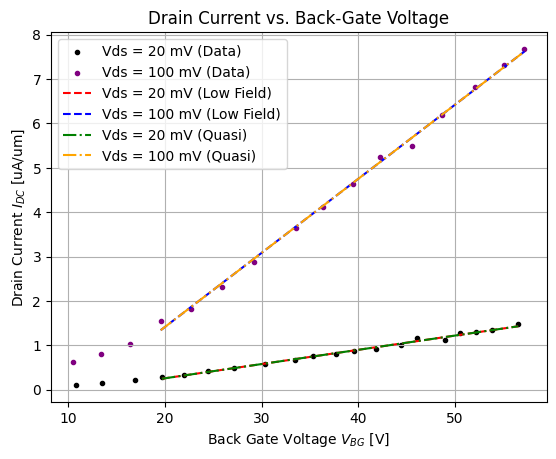

In [188]:
# Plot the fit
plot_Vg1 = experimental_Vbg1[np.where(experimental_Vbg1 >= 10)]
plot_Id1 = experimental_Id1[np.where(experimental_Vbg1 >= 10)]

plot_Vg2 = experimental_Vbg2[np.where(experimental_Vbg2 >= 10)]
plot_Id2 = experimental_Id2[np.where(experimental_Vbg2 >= 10)]

plot = plt.scatter(plot_Vg1, plot_Id1, color="black", marker='.')
plt.scatter(plot_Vg2, plot_Id2, color="purple", marker='.')

plt.plot(positive_V_Vbg1, low_result_20mV.best_fit , "red", linestyle ='--')
plt.plot(positive_V_Vbg2, low_result_100mV.best_fit, "blue", linestyle ='--')

plt.plot(positive_V_Vbg1, quasi_result_20mV.best_fit , "green", linestyle ='-.')
plt.plot(positive_V_Vbg2, quasi_result_100mV.best_fit, "orange", linestyle ='-.')

# plt.yscale("log")
plt.title("Drain Current vs. Back-Gate Voltage")
plt.legend(["Vds = 20 mV (Data)", "Vds = 100 mV (Data)","Vds = 20 mV (Low Field)", "Vds = 100 mV (Low Field)","Vds = 20 mV (Quasi)", "Vds = 100 mV (Quasi)"], loc="upper left")
plt.xlabel(r"Back Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("low_field_quasi_VbG.png", dpi=300, bbox_inches='tight')
plt.show()

# $I_{DS}(V_{DS})$

In [189]:
lin_path = os.path.join(r"C:\Users\elias/Desktop\EE230", 'Vds_all.csv')
lin_curve = read_csv(lin_path)

In [190]:
Vds_range = np.linspace(0, 100, 1000)

60.0
62.36362122155401
: Vg = 62.363621 +/- 0.000000, Vref = 12.432872 +/- 0.000000, mu = 42.000000 +/- 0.000000, chi-square = 0.000000
60.0
46.32860960749301
: Vg = 46.328610 +/- 0.000000, Vref = 12.432872 +/- 0.000000, mu = 42.000000 +/- 0.000000, chi-square = 0.000000
47.65942917130036
26.71837973413426
: Vg = 26.718380 +/- 0.000000, Vref = 12.432872 +/- 0.000000, mu = 42.000000 +/- 0.000000, chi-square = 0.000000
17.931774514277265
14.662854737335064
: Vg = 14.662855 +/- 0.000000, Vref = 12.432872 +/- 0.000000, mu = 42.000000 +/- 0.000000, chi-square = 0.000000
12.249225112617896
12.35839725019215
: Vg = 12.358397 +/- 0.000000, Vref = 12.432872 +/- 0.000000, mu = 42.000000 +/- 0.000000, chi-square = 0.000000


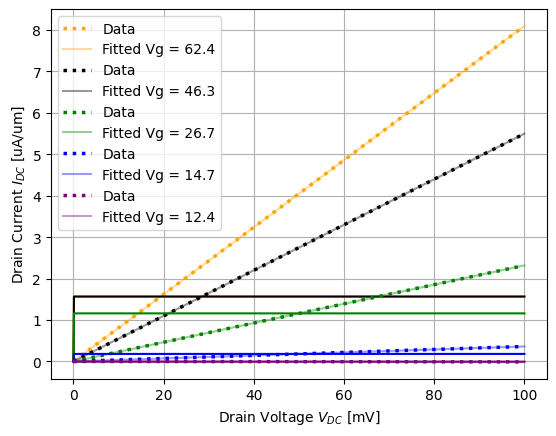

In [193]:
colors = ["orange", "black", "green", "blue", "purple"]

for each, col in zip(lin_curve, colors):
    plt.plot([0, each[0]], [0, each[1]], col, linestyle=":", label="Data", linewidth=2.5)

    Islope = each[1]/each[0]
    Idata = Vds_range*Islope

    if (each[1]!=0):
        # Quasi_IVmodel = Model(Quasi_I_V_function, ['Vds'])

        # quasi_params = Quasi_IVmodel.make_params(
        #     Vg = dict(value=60, min=0, max=60),
        #     Cfit = dict(value = 3e-4, vary=False),
        #     Vref = dict(value=12.432872, vary=False),
        #     leff_lambda = dict(value=600, vary=False),
        #     r = dict(value=0.8, vary=False)
        #     )

        # quasi_result = Quasi_IVmodel.fit(Idata, quasi_params, Vds = Vds_range)
        # print(quasi_result.params['Vg'].value)
        # plt.plot(Vds_range, quasi_result.best_fit, col)

        Low_IVmodel = Model(Low_I_V_function, ['Vds'])

        low_params = Low_IVmodel.make_params(
            Vg = dict(value=60, min=0, vary=True),
            Vref = dict(value=12.432872, vary=False),
            mu = dict(value=42, vary=False)
            )

        low_result = Low_IVmodel.fit(Idata, low_params, Vds = 1e-3*Vds_range)
        print(low_result.params['Vg'].value)
        plt.plot(Vds_range, low_result.best_fit, color=col, alpha=0.4, label=f"Fitted Vg = {low_result.params['Vg'].value:.1f}")

        print(": Vg = %f +/- %f, Vref = %f +/- %f, mu = %f +/- %f, chi-square = %f" % (low_result.params['Vg'].value, 
                                                                    low_result.params['Vg'].stderr,
                                                                    low_result.params['Vref'].value, 
                                                                    low_result.params['Vref'].stderr,
                                                                    low_result.params['mu'].value, 
                                                                    low_result.params['mu'].stderr,
                                                                    low_result.chisqr))
plt.legend()
plt.xlabel(r"Drain Voltage $V_{DC}$ [mV]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("real_Vds.png", dpi=300, bbox_inches='tight')
plt.show()